In [286]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline


print('Libraries imported.')

Libraries imported.


#### Reading venue data stored on Git into city_venues

In [428]:
city_venues=pd.read_csv("https://raw.githubusercontent.com/dibyendutapadar/mumbai_city_analysis/master/Mumbai_venues.csv")
city_venues.drop(['Unnamed: 0'],axis=1,inplace=True)

print(city_venues.shape)
city_venues.head()

(26814, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,19.156129,72.870722,The Westin Mumbai Garden City,19.172654,72.860518,Hotel
1,Aarey Milk Colony,19.156129,72.870722,PVR Cinemas,19.174016,72.860485,Multiplex
2,Aarey Milk Colony,19.156129,72.870722,Film City,19.160960,72.886177,Event Space
3,Aarey Milk Colony,19.156129,72.870722,Starbucks,19.174177,72.860350,Coffee Shop
4,Aarey Milk Colony,19.156129,72.870722,British Brewing Company (BBC),19.174186,72.860504,Brewery


,Venue Category,Neighborhood
0,ATM,1
1,Accessories Store,1
2,Afghan Restaurant,19
3,Airport,20
4,Airport Lounge,8
5,American Restaurant,148
6,Antique Shop,1
7,Arcade,65
8,Art Gallery,15
9,Arts & Crafts Store,3


### there are about 236 venue_types in the file. A lot of them are overlapping and similar. for the purpose of analysis, we have reduced the venue types to 14 and the existing venue types are mapped to the new venue types intended at understanding the type of locality

In [429]:
venue_map=pd.read_csv('https://raw.githubusercontent.com/dibyendutapadar/mumbai_city_analysis/master/venue_category_mapping.csv',encoding='latin-1')
venue_map['Venue Mapping'].unique()

array(['regular_restaurants', 'nature_view', 'tourist_interest',
       'shopping', 'transport_vicinity', 'business_hub',
       'stores_daily_conveniences', 'sports_fitness', 'café_fastfoods',
       'cuisine_restaurants', 'arts_culture_recreation', 'bars_nightlife',
       'kids_family_residential', 'education_colleges'], dtype=object)

### Merging the mapped venues wiuth the exoisting venue categories

In [430]:
city_venue=pd.merge(city_venues,venue_map,on='Venue Category',how='left')
city_venue.head().sort_values('Neighborhood',ascending=True)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Mapping
0,Aarey Milk Colony,19.156129,72.870722,The Westin Mumbai Garden City,19.172654,72.860518,Hotel,tourist_interest
1,Aarey Milk Colony,19.156129,72.870722,PVR Cinemas,19.174016,72.860485,Multiplex,arts_culture_recreation
2,Aarey Milk Colony,19.156129,72.870722,Film City,19.160960,72.886177,Event Space,arts_culture_recreation
3,Aarey Milk Colony,19.156129,72.870722,Starbucks,19.174177,72.860350,Coffee Shop,café_fastfoods
4,Aarey Milk Colony,19.156129,72.870722,British Brewing Company (BBC),19.174186,72.860504,Brewery,bars_nightlife


In [431]:
venue_count=city_venue[['Venue Mapping','Neighborhood']].groupby('Venue Mapping',as_index=False).count()
venue_count.rename(columns={'Neighborhood':'count'},inplace=True)
venue_count.head()

,Venue Mapping,count
0,arts_culture_recreation,1086
1,bars_nightlife,2324
2,business_hub,28
3,café_fastfoods,5406
4,cuisine_restaurants,1440


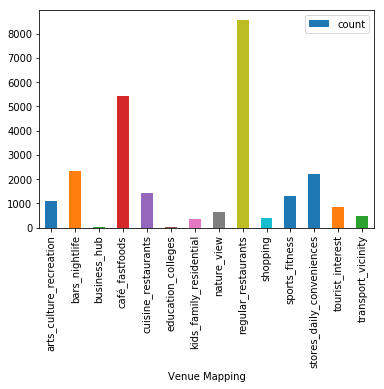

In [432]:
ax = venue_count.plot.bar(x='Venue Mapping', y='count')

In [433]:
venue_count['importance']=venue_count['count'].min()/venue_count['count']
venue_count

,Venue Mapping,count,importance
0,arts_culture_recreation,1086,0.023020
1,bars_nightlife,2324,0.010757
2,business_hub,28,0.892857
3,café_fastfoods,5406,0.004624
4,cuisine_restaurants,1440,0.017361
5,education_colleges,25,1.000000
6,kids_family_residential,369,0.067751
7,nature_view,630,0.039683
8,regular_restaurants,8542,0.002927
9,shopping,375,0.066667


In [434]:
venue_counts=venue_count.drop('count',1)
venue_counts_t=venue_counts.T
venue_counts_t.columns=venue_counts['Venue Mapping']
venue_counts_t.drop('Venue Mapping',inplace=True)
venue_counts_t

Venue Mapping,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
importance,0.0230203,0.0107573,0.892857,0.00462449,0.0173611,1,0.0677507,0.0396825,0.00292672,0.0666667,0.019084,0.0113688,0.0295508,0.0520833


In [435]:
city_onehot = pd.get_dummies(city_venue[['Venue Mapping']], prefix="", prefix_sep="")
#print(Toronto_onehot.head())
# add neighborhood column back to dataframe
city_onehot['Neighborhood'] = city_venue['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head().sort_values('Neighborhood',ascending=True)

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Aarey Milk Colony,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Aarey Milk Colony,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Aarey Milk Colony,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Aarey Milk Colony,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [338]:
## Grouping Neighborhoods by the sum of the venue_types

In [436]:
city_grouped = city_onehot.groupby('Neighborhood').sum().reset_index()
city_grouped

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,Abhyudaya Nagar,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,Airoli,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,Alika Nagar,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,Ambedkar Nagar,3,14,0,22,12,1,2,2,18,0,7,10,0,1
5,Amboli,3,15,0,22,7,1,1,0,32,0,4,9,1,0
6,Amrut Nagar,2,13,0,19,7,0,1,2,29,3,8,9,3,0
7,Anand Nagar,3,8,0,24,6,0,3,4,31,0,5,11,4,0
8,Andheri (East),1,9,0,25,5,1,0,0,41,0,0,5,8,0
9,Andheri (West),3,19,0,22,7,0,1,2,29,0,0,6,2,0


In [437]:
# normalizing data  


#for k in range(1,15):
#    city_grouped[city_grouped.columns[k]]=(city_grouped[city_grouped.columns[k]]/city_grouped[city_grouped.columns[k]].max())
city_grouped.head()

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,Abhyudaya Nagar,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,Airoli,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,Alika Nagar,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,Ambedkar Nagar,3,14,0,22,12,1,2,2,18,0,7,10,0,1


In [341]:
## function to return the top venues per neighborhood

In [438]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [439]:
num_top_venues = 5
city_group_common=city_grouped.drop('regular_restaurants',1).drop('café_fastfoods',1)
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = city_group_common['Neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_group_common.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aarey Milk Colony,stores_daily_conveniences,bars_nightlife,arts_culture_recreation,sports_fitness,cuisine_restaurants
1,Abhyudaya Nagar,bars_nightlife,stores_daily_conveniences,cuisine_restaurants,arts_culture_recreation,tourist_interest
2,Airoli,transport_vicinity,stores_daily_conveniences,bars_nightlife,tourist_interest,sports_fitness
3,Alika Nagar,stores_daily_conveniences,bars_nightlife,sports_fitness,arts_culture_recreation,transport_vicinity
4,Ambedkar Nagar,bars_nightlife,cuisine_restaurants,stores_daily_conveniences,sports_fitness,arts_culture_recreation


In [440]:
city_grouped_clustering = city_grouped.drop(['Neighborhood'], 1)
city_grouped_clustering.head()

,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,3,14,0,22,12,1,2,2,18,0,7,10,0,1


In [441]:
city_grouped_clustering_analysis=city_grouped_clustering.multiply(venue_counts_t.values[0])
city_grouped_clustering_analysis.head()

,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,0.115101,0.0645439,0.892857,0.0462449,0.0347222,0,0.0677507,0.0396825,0.0585343,0.0666667,0.0572519,0.0795816,0.0295508,0
1,0.138122,0.129088,0.892857,0.0693674,0.121528,0,0,0.0396825,0.0878015,0.2,0.0763359,0.102319,0.118203,0.0520833
2,0,0.0215146,0,0.0231225,0,0,0,0,0.020487,0,0,0.0227376,0,0.208333
3,0.092081,0.0537866,0.892857,0.0601184,0,0,0.135501,0,0.0585343,0.0666667,0.0763359,0.0682128,0,0.15625
4,0.0690608,0.150602,0,0.101739,0.208333,1,0.135501,0.0793651,0.0526809,0,0.133588,0.113688,0,0.0520833


In [442]:
# dropping stores regular restaurants and cafes as they are quite abundant and available in each areas



distance=[]

kclusters= range(1,50)
for k in kclusters:
# run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(city_grouped_clustering)
    distance.append(kmeans.inertia_)

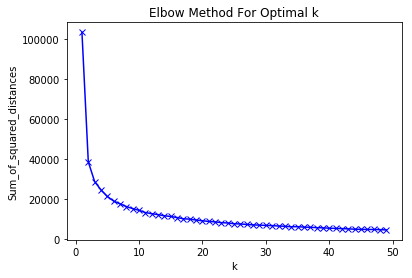

In [443]:
# Checking the elbow to find th emost desirable K-value

plt.plot(kclusters,distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [444]:
# selecting the number of clusters as 10

kclusters = 10


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
 
#neighborhoods_venues_sorted.drop(['Cluster Labels'],axis=1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [445]:
# defining the final city data with cluster
city_final = city_venue

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_final = city_venue.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# 
city_plot=city_final[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Cluster Labels']].groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],as_index=False).mean()
city_plot.sort_values(['Neighborhood','Cluster Labels'])

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels
0,Aarey Milk Colony,19.156129,72.870722,0
1,Abhyudaya Nagar,18.990477,72.844057,8
2,Airoli,19.158515,72.999402,7
3,Alika Nagar,19.198397,72.874267,0
4,Ambedkar Nagar,19.070822,72.828865,9
5,Amboli,19.132010,72.849864,4
6,Amrut Nagar,19.100845,72.911820,4
7,Anand Nagar,18.966523,72.811888,3
8,Andheri (East),19.115883,72.854202,1
9,Andheri (West),19.117249,72.833968,4


In [356]:
## Checking the distribution of the clusters

In [446]:
clusters=city_plot[['Neighborhood','Cluster Labels']].groupby(['Cluster Labels'],as_index=False).count().sort_values('Neighborhood',ascending=False)
clusters.sort_values('Cluster Labels')

,Cluster Labels,Neighborhood
0,0,30
1,1,41
2,2,30
3,3,27
4,4,33
5,5,29
6,6,40
7,7,61
8,8,49
9,9,27


In [358]:
# Checking the most common venue for each clusters

In [447]:

cluster_label_1=city_final[['Cluster Labels','1st Most Common Venue','Neighborhood']].groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)

cluster_label_1.rename(columns={'1st Most Common Venue':'Common Venue'},inplace=True)
cluster_label_1.head()

,Cluster Labels,Common Venue,Neighborhood
42,9,bars_nightlife,2400
43,9,stores_daily_conveniences,300
40,8,stores_daily_conveniences,1407
41,8,tourist_interest,1353
38,8,cuisine_restaurants,983


In [448]:
cluster_label_2=city_final[['Cluster Labels','2nd Most Common Venue','Neighborhood']].groupby(['Cluster Labels','2nd Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)
cluster_label_2.rename(columns={'2nd Most Common Venue':'Common Venue'},inplace=True)
cluster_label_2.head()

,Cluster Labels,Common Venue,Neighborhood
55,9,stores_daily_conveniences,1600
54,9,cuisine_restaurants,800
53,9,bars_nightlife,300
48,8,bars_nightlife,2354
51,8,stores_daily_conveniences,1666


In [449]:
cluster_label_3=city_final[['Cluster Labels','3rd Most Common Venue','Neighborhood']].groupby(['Cluster Labels','3rd Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)
cluster_label_3.rename(columns={'3rd Most Common Venue':'Common Venue'},inplace=True)
cluster_label_3.head()

,Cluster Labels,Common Venue,Neighborhood
62,9,cuisine_restaurants,1700
64,9,stores_daily_conveniences,800
63,9,sports_fitness,200
57,8,cuisine_restaurants,1409
60,8,stores_daily_conveniences,957


In [450]:
cluster_label=pd.concat([cluster_label_1,cluster_label_2,cluster_label_3])
cluster_label=cluster_label.groupby(['Cluster Labels','Common Venue'],as_index=False).sum()
cluster_label

,Cluster Labels,Common Venue,Neighborhood
0,0,arts_culture_recreation,141
1,0,bars_nightlife,993
2,0,cuisine_restaurants,868
3,0,nature_view,425
4,0,shopping,76
5,0,sports_fitness,1367
6,0,stores_daily_conveniences,2084
7,0,tourist_interest,366
8,0,transport_vicinity,124
9,1,arts_culture_recreation,200


width: 0.05


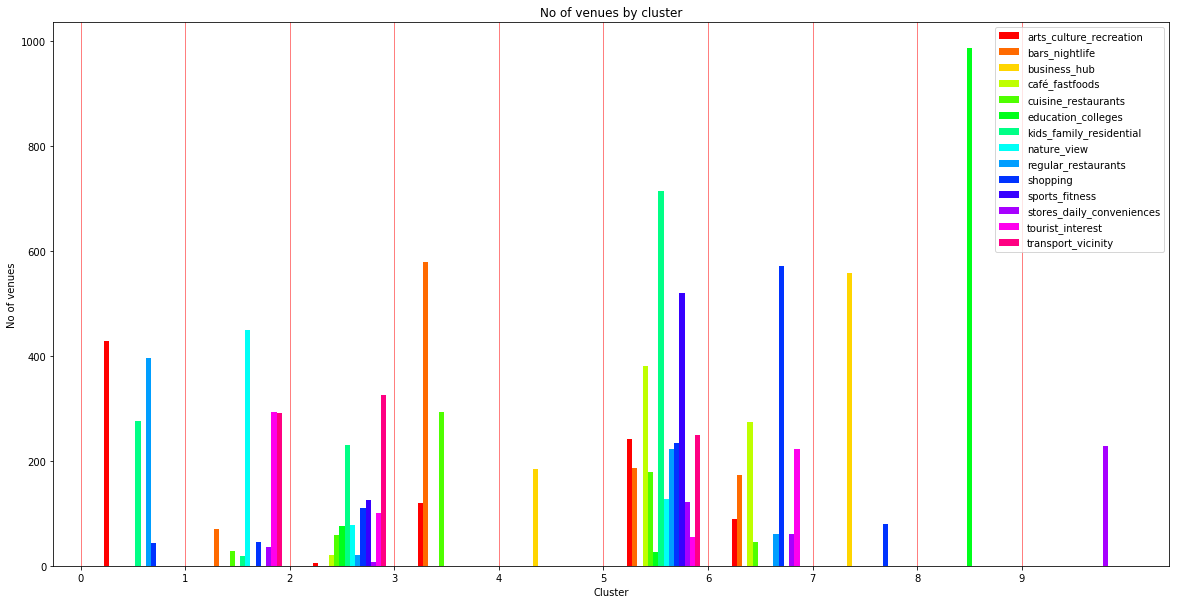

In [451]:
cluster_label_array= cluster_label_.values
fig = plt.figure(figsize=(20,10)) 
ax = plt.subplot()

space = .5

conditions = np.unique(cluster_label_array[:,0])
categories = np.unique(cluster_label_array[:,1])
#print(conditions)
#print(categories)
n = len(conditions)

width = (1 - space) / (len(conditions))
print ("width:", width)

for i,cat in enumerate(categories):
    vals=[0]*10
    val = cluster_label_array[cluster_label_array[:,1] == cat][:,2].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width-.5 for j in range(1,n+1)]
    num=cluster_label_array[cluster_label_array[:,1] == cat][:,0]
    for k in range(0,len(num)):
        vals[num[k]]=val[k]
    ax.bar(pos,vals, width=width,label=cat,color=cm.hsv(float(i) / len(categories)))

xticks=np.arange(n)

xticks1=[",".join(item) for item in xticks.astype(str)]

ax.set_xticks(xticks)
ax.set_xlabel('Cluster')
ax.set_ylabel('No of venues')
ax.set_title('No of venues by cluster')
ax.grid(linestyle='-', linewidth='0.5',axis='x', color='red')
ax.legend()

In [452]:
data={0:'Chilled out Neighborhoods',
      1:'Places with nature/sea view and tourist attraction',
      2:'Low profile residential areas (far off)',
      3:'Hip and Happening',
      4:'Business Hubs and offices',
      5:'Good for post-retirement homes',
      6:'Low profile residential areas (suburbs)',
      7:'Open spaces for sports and fitness enthusiasts',
      8:'Posh Areas',
      9:'High Profile Residential Area',}

cluster_label_name= pd.Series(data).to_frame(name='label')
cluster_label_name


,label
0,Chilled out Neighborhoods
1,Places with nature/sea view and tourist attrac...
2,Low profile residential areas (far off)
3,Hip and Happening
4,Business Hubs and offices
5,Good for post-retirement homes
6,Low profile residential areas (suburbs)
7,Open spaces for sports and fitness enthusiasts
8,Posh Areas
9,High Profile Residential Area


In [423]:
# create map
latitude = city_plot['Neighborhood Latitude'].mean()
longitude = city_plot['Neighborhood Longitude'].mean()


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.tab10(np.linspace(0, 1, len(ys)))

col_scale = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_plot['Neighborhood Latitude'], city_plot['Neighborhood Longitude'], city_plot['Neighborhood'], city_plot['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7.5,
        popup=label,
        color=None,
        fill=True,
        fill_color=col_scale[cluster],
        fill_opacity=.8).add_to(map_clusters)

# Creating legend
for c in range(0,len(colors_array)):
    r=int(colors_array[c][0]*255)
    g=int(colors_array[c][1]*255)
    b=int(colors_array[c][2]*255)
    group =folium.FeatureGroup(name='<span style=\\"color:rgb({},{},{},{});\\">{}</span>'.format(r,g,b,1,str(c)+"-"+cluster_label_name.iloc[c]['label']))
    group.add_to(map_clusters)


folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)



map_clusters.save(outfile="clusters.html")

In [371]:
city_final[['Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].drop_duplicates().sort_values('Cluster Labels')

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18611,0,regular_restaurants,café_fastfoods,stores_daily_conveniences,cuisine_restaurants,nature_view
4054,0,regular_restaurants,café_fastfoods,stores_daily_conveniences,sports_fitness,bars_nightlife
5003,0,nature_view,tourist_interest,transport_vicinity,stores_daily_conveniences,sports_fitness
14128,0,café_fastfoods,regular_restaurants,nature_view,cuisine_restaurants,stores_daily_conveniences
12494,0,regular_restaurants,café_fastfoods,stores_daily_conveniences,tourist_interest,bars_nightlife
16217,0,regular_restaurants,café_fastfoods,sports_fitness,stores_daily_conveniences,bars_nightlife
17013,0,regular_restaurants,café_fastfoods,stores_daily_conveniences,sports_fitness,nature_view
11756,0,nature_view,tourist_interest,stores_daily_conveniences,regular_restaurants,cuisine_restaurants
11707,0,regular_restaurants,nature_view,stores_daily_conveniences,sports_fitness,bars_nightlife
17382,0,regular_restaurants,café_fastfoods,cuisine_restaurants,stores_daily_conveniences,sports_fitness


In [372]:
(city_final[['Cluster Labels','1st Most Common Venue','Neighborhood']].groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).count()).groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).max()

,Cluster Labels,1st Most Common Venue,Neighborhood
0,0,café_fastfoods,42
1,0,nature_view,58
2,0,regular_restaurants,1977
3,1,café_fastfoods,800
4,1,regular_restaurants,1680
5,2,regular_restaurants,2540
6,3,café_fastfoods,85
7,3,regular_restaurants,4849
8,4,café_fastfoods,93
9,4,regular_restaurants,975


In [468]:
latitude = city_plot['Neighborhood Latitude'].mean()
longitude = city_plot['Neighborhood Longitude'].mean()


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)



city_data=pd.read_csv("https://raw.githubusercontent.com/dibyendutapadar/mumbai_city_analysis/master/pp_latlong.csv")
city_pp=city_data[['Locality Name','buy_rate_avg','Latitude','Longitude']]
city_pp['price_label']=city_pp['Locality Name']+" -Rs."+city_pp['buy_rate_avg'].astype(str)+"/sq.ft"
city_pp.dropna(inplace=True)
city_plot2=city_pp[['Latitude','Longitude','buy_rate_avg']].dropna().groupby(['Latitude','Longitude'],as_index=False).mean()


HeatMap( list(zip(city_plot2.Latitude, city_plot2.Longitude, city_plot2['buy_rate_avg'])),
                   min_opacity=0.8,
                   max_val=45000,
                   radius=20, 
                   blur=50,
                   max_zoom=5, 
                 ).add_to(map_clusters)



#set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.tab10(np.linspace(0, 1, len(ys)))

col_scale = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_plot['Neighborhood Latitude'], city_plot['Neighborhood Longitude'], city_plot['Neighborhood'], city_plot['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=None,
        fill=True,
        fill_color=col_scale[cluster],
        fill_opacity=1).add_to(map_clusters)

# Creating legend
for c in range(0,len(colors_array)):
    r=int(colors_array[c][0]*255)
    g=int(colors_array[c][1]*255)
    b=int(colors_array[c][2]*255)
    group =folium.FeatureGroup(name='<span style=\\"color:rgb({},{},{},{});\\">{}</span>'.format(r,g,b,1,str(c)+"-"+cluster_label_name.iloc[c]['label']))
    group.add_to(map_clusters)


folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)



map_clusters.save(outfile= "Final_map.html")

C:\Users\23165948\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\23165948\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
